# Measure classification performance in logistic regressions

Spotify assigns 13 different musical attributes/features to each song (see this [link](https://developer.spotify.com/console/get-audio-features-track/)). These song attributes, or features, are used to recommend new music to spotify's users. The features are mostly numerical values. Spotify also assigns a **popularity score** based on the total number of clicks for a given song. Alternatively, you can get a sample from [kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features/home).

The question is: can we classify songs as "popular" based on their musical attributes?

In [ ]:
# load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
# useful libraries for k-fold CV for cross-sectional data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

We can convert any continous variable $y$ into a binary response by defining a **thershold** value. That is, if y > thershold then y = 1, else y = 0. 

Get data and add a wrapper to use the logistic function from `statsmodels`

In [ ]:
# this is the address where the data is at github
url='https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_2/spotify.csv'

# load it into a data frame
col_names = ['artist', 'track_id', 'track_name', 'acousticness', 'danceability',
             'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 
             'loudness','mode', 'speechiness', 'tempo', 'time_signature', 
             'valence', 'popularity']

# read csv file
df = pd.read_csv(url, delimiter=',', names=col_names, header=1)

Plot popularity scores

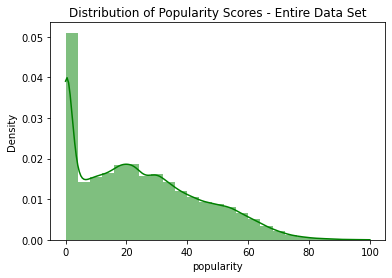

In [ ]:
fig = plt.figure()
sns.histplot(df['popularity'], color='g', label="Popularity Score",\
                 kde=True, stat="density", linewidth=0, bins=25)\
               .set_title("Distribution of Popularity Scores - Entire Data Set")
plt.show()

## Effect of the threshold value on model performance
We measure model performance for our classifier using the area under the ROC curve, commonly called AUC. Further, we use 3 different threshold values and for each value we run a 5-folds cross validation. Finally, we plot the receiver operating chracteristic (ROC) curve for each threshold, together with its standard deviation and AUC value.

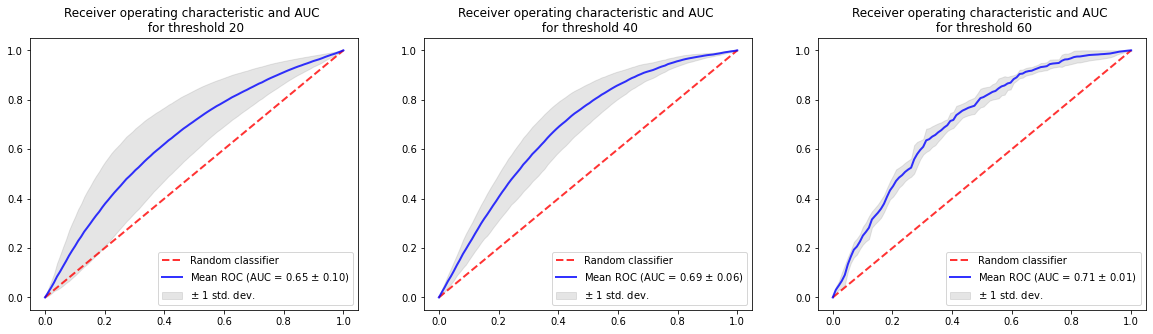

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
thresholds = [20,40,60]
all_df =[]
cm = 0 # we will save confusion matrix for each CV

for i, threshold in enumerate(thresholds):
  # define binary variable
  df['pop_bin'] = np.where(df['popularity'] > threshold, 1, 0)

  # features to use as predictors/covariates
  x = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness'
      ,'liveness','loudness','mode','speechiness','tempo','time_signature',\
      'valence']
  y = ['pop_bin']

  # get x and y
  x = df[x].values
  y = df[y].values

  # define different number of folds
  Ks = 5
  kfolds = KFold(n_splits=Ks)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  for j, (train,test) in  enumerate(kfolds.split(x,y=y)):
    # define and fit the model in statsmodels
    classifier = sm.Logit(y[train],x[train]).fit(disp=0)
    
    fpr,tpr,thresholds = metrics.roc_curve(y[test],classifier.predict(x[test]))
    roc_auc = metrics.auc(fpr, tpr)
    # remember to use a meaningfull threshold
    cm += classifier.pred_table(threshold = y.sum()/y.shape[0])

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
  
  # confusion matrix using statsmodels
  cm_df = pd.DataFrame(cm/Ks,
                     columns=['Predicted 0', 'Predicted 1'],
                     index = pd.Series(['Actual 0','Actual 1']))
  # save cm_df in a list
  # only the last trained lr from
  # the 5-fold cv
  all_df.append(cm_df)

  ax[i].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random classifier", alpha=0.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = metrics.auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax[i].plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax[i].fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax[i].set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title="Receiver operating characteristic and AUC \n for threshold {}"\
      .format(threshold),
  )
  ax[i].legend(loc="lower right")


plt.show()

In [ ]:
print('Confusion Matrix for threshold 20 \n',all_df[0],'\n\n')
print('Confusion Matrix for threshold 40 \n',all_df[1],'\n\n')
print('Confusion Matrix for threshold 60 \n',all_df[2],'\n\n')

Confusion Matrix for threshold 20 
           Predicted 0  Predicted 1
Actual 0      27249.0      23037.4
Actual 1      16348.0      37895.2 


Confusion Matrix for threshold 40 
           Predicted 0  Predicted 1
Actual 0      74376.4      57650.8
Actual 1      22251.6      54780.4 


Confusion Matrix for threshold 60 
           Predicted 0  Predicted 1
Actual 0     132224.4      99168.4
Actual 1      23399.0      58797.0 




**NOTE:** We obtained the confusion matrix for each cross-validation. Then we took the average, hence the decimal points. Further, the confusion matrix that we got from `statsmodels` is based on the training data set. If you want more meaningfull number, you should used the test data set. However, I did not find the way to get a confunsion matrix based on the test data set using `statsmodels`, but here you have the way you get the confusion matrix with `scikitlearn`

In [ ]:
# first get the predictions y_hat
y_hat = [ 0 if pr < y.sum()/y.shape[0] else 1 for pr in classifier.predict(x[test])]

# now get the confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y[test], y_hat).ravel()

cm_df = pd.DataFrame(np.array([[tn, fp],
                               [fn, tp]]),
             columns=['Predicted 0', 'Predicted 1'],
             index = pd.Series(['Actual 0','Actual 1']))

In [ ]:
print('Confusion Matrix for threshold 60 \n',cm_df)

Confusion Matrix for threshold 60 
           Predicted 0  Predicted 1
Actual 0        20835         1012
Actual 1         3873          412


Note that in the above example I just showed how to use `scikitlearn` using the last model (threshold = 60) and the last iteration in the 5-folds cross validation. You should implement the above approach inside the 5-folds cross valiation and get average numbers for tp, fp, tn, fn, just as we did with the `statsmodels` library!!